In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import ast

import gurobipy as gp
from gurobipy import GRB, Model
import math

import warnings
warnings.filterwarnings('ignore')

In [2]:
monthly_returns = pd.read_csv("tickers_monthly_returns_percentage_2023.csv")

In [3]:
monthly_returns

,ticker,month,monthly_return_percentage
0,PJAA.JK,2023-01,-2.816654
1,PJAA.JK,2023-02,-1.449144
2,PJAA.JK,2023-03,0.000000
3,PJAA.JK,2023-04,1.428444
4,PJAA.JK,2023-05,2.554153
...,...,...,...
10439,BABY.JK,2023-12,-15.714286
10440,AEGS.JK,2023-09,-32.631579
10441,AEGS.JK,2023-10,-15.873016
10442,AEGS.JK,2023-11,18.367347


In [4]:
# parsing string list
def parse_column(column):
    return column.apply(lambda x: ast.literal_eval(x))

# simulasi portfolio
def simulate_portfolio(df, monthly_returns, initial_fund=1e8): # 100_000_000
    portfolio_value = initial_fund
    portfolio_history = []

    for i, row in df.iterrows():
        month = row['Month']
        stock_list = row['stock']
        weights = row['weight']

        # alokasi setiap bulan
        stock_allocations = {stock: portfolio_value * float(weight) for stock, weight in zip(stock_list, weights)}
        
        # update nilai alokasi
        for stock, allocation in stock_allocations.items():
            stock_return = monthly_returns[(monthly_returns['ticker'] == stock) & (monthly_returns['month'] == month)]
            if not stock_return.empty:
                # persentase return bulanan
                return_percentage = float(stock_return['monthly_return_percentage'].values[0]) / 100
                # update nilai alokasi saham berdasarkan return bulanan
                stock_allocations[stock] = allocation * (1 + return_percentage)

        # total nilai total portofolio setelah return
        portfolio_value = sum(stock_allocations.values())
        portfolio_history.append({'Month': month, 'Portfolio Value': portfolio_value})

    return pd.DataFrame(portfolio_history)

In [5]:
# lookback 30 days
df_30 = pd.read_csv("lookback_30.csv")
df_30['stock'] = parse_column(df_30['stock'])
df_30['weight'] = parse_column(df_30['weight'])

portfolio_history_30 = simulate_portfolio(df_30, monthly_returns)
portfolio_history_30

,Month,Portfolio Value
0,2023-01,9.628093e+07
1,2023-02,9.027224e+07
2,2023-03,2.331392e+08
3,2023-04,2.568124e+08
4,2023-05,2.345657e+08
5,2023-06,2.382272e+08
6,2023-07,3.116366e+08
7,2023-08,2.460590e+08
8,2023-09,2.437400e+08
9,2023-10,2.424738e+08


In [6]:
# lookback 60 days
df_60 = pd.read_csv("lookback_60.csv")
df_60['stock'] = parse_column(df_60['stock'])
df_60['weight'] = parse_column(df_60['weight'])

portfolio_history_60 = simulate_portfolio(df_60, monthly_returns)
portfolio_history_60

,Month,Portfolio Value
0,2023-01,9.862595e+07
1,2023-02,1.679170e+08
2,2023-03,4.339939e+08
3,2023-04,4.831996e+08
4,2023-05,4.917652e+08
5,2023-06,5.009418e+08
6,2023-07,6.075381e+08
7,2023-08,3.444227e+08
8,2023-09,3.356064e+08
9,2023-10,3.324838e+08


In [7]:
# lookback 90 days
df_90 = pd.read_csv("lookback_90.csv")
df_90['stock'] = parse_column(df_90['stock'])
df_90['weight'] = parse_column(df_90['weight'])

portfolio_history_90 = simulate_portfolio(df_90, monthly_returns)
portfolio_history_90

,Month,Portfolio Value
0,2023-01,9.899254e+07
1,2023-02,8.311636e+07
2,2023-03,6.892191e+07
3,2023-04,7.592031e+07
4,2023-05,7.761775e+07
5,2023-06,7.906614e+07
6,2023-07,8.376670e+07
7,2023-08,1.093176e+08
8,2023-09,1.401619e+08
9,2023-10,1.780358e+08


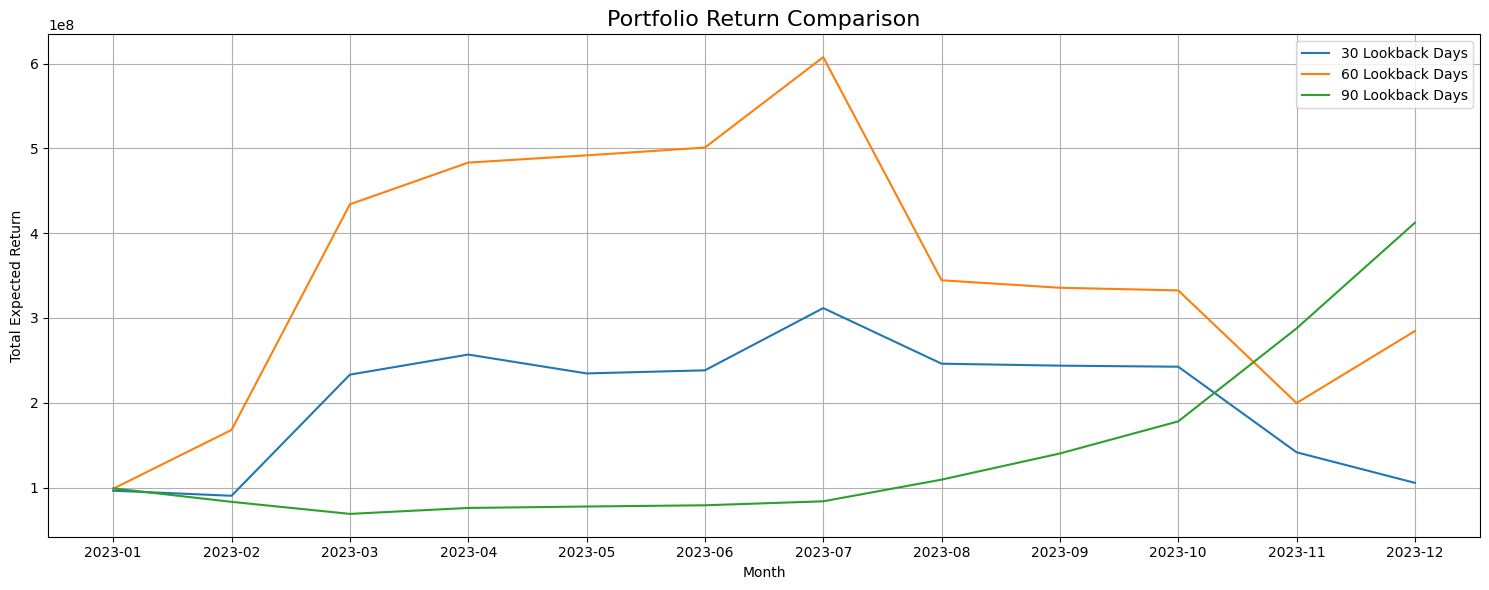

In [8]:
dataframes = [portfolio_history_30,
              portfolio_history_60,
              portfolio_history_90]
labels = ["30 Lookback Days",
          "60 Lookback Days",
          "90 Lookback Days"]

plt.figure(figsize=(15, 6))
for df, label in zip(dataframes, labels):
    plt.plot(df['Month'], df['Portfolio Value'], label=label)

plt.xlabel('Month')
plt.ylabel('Total Expected Return')
plt.title('Portfolio Return Comparison', fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
def calculate_metrics(df_1, df_2, label):
    annualized_return = (df_2['Portfolio Value'].iloc[-1] / df_2['Portfolio Value'].iloc[0] - 1) * 100
    volatility = df_1['portfolio_risk'].iloc[-1]
    drawdown = max(0, (df_2['Portfolio Value'].max() - df_2['Portfolio Value'].min()))

    return {
        'Label': label,
        'Annualized Return': f"{annualized_return:.2f}%",
        'Risk - Volatility': f"{volatility:.2f}%",
        'Drawdown': f"{drawdown:.2f}%",
    }

metrics_list = []
metrics_list.append(calculate_metrics(df_30, portfolio_history_30, "30 Lookback Days Portfolio"))
metrics_list.append(calculate_metrics(df_60, portfolio_history_60, "60 Lookback Days Portfolio"))
metrics_list.append(calculate_metrics(df_90, portfolio_history_90, "90 Lookback Days Portfolio"))

print("Highlights")
# print("Return")
for metrics in metrics_list:
    print(f"{metrics['Label']}:")
    print(f"  Annualized Return: {metrics['Annualized Return']}")
    print(f"  Risk - Volatility: {metrics['Risk - Volatility']}")
    print(f"  Drawdown: {metrics['Drawdown']}")
    print()


Highlights
30 Lookback Days Portfolio:
  Annualized Return: 9.60%
  Risk - Volatility: 12.76%
  Drawdown: 221364382.70%

60 Lookback Days Portfolio:
  Annualized Return: 188.55%
  Risk - Volatility: 5.79%
  Drawdown: 508912174.35%

90 Lookback Days Portfolio:
  Annualized Return: 316.41%
  Risk - Volatility: 5.81%
  Drawdown: 343295043.25%



# Comparison w/ LQ45

In [10]:
df_lq45 = pd.read_csv("data_historis_jakarta_stock_exchange_lq45.csv")
df_lq45['Tanggal'] = pd.to_datetime(df_lq45['Tanggal'], format='%d/%m/%Y').dt.strftime('%Y-%m-%d')

In [11]:
# replace commas & convert to float
columns = ['Terakhir', 'Pembukaan', 'Tertinggi', 'Terendah']
for col in columns:
    df_lq45[col] = df_lq45[col].str.replace('.', '').str.replace(',', '.').astype(float)

In [12]:
df_lq45 = df_lq45.sort_values(by='Tanggal').reset_index(drop=True)
df_lq45

,Tanggal,Terakhir,Pembukaan,Tertinggi,Terendah,Vol.,Perubahan%
0,2020-01-02,1011.62,1017.16,1017.52,1007.50,"612,73M","-0,28%"
1,2020-01-03,1021.49,1016.72,1021.49,1012.97,"1,08B","0,98%"
2,2020-01-06,1010.23,1012.93,1016.16,1005.83,"1,12B","-1,10%"
3,2020-01-07,1014.64,1013.78,1016.53,1008.49,"1,19B","0,44%"
4,2020-01-08,1005.45,1007.10,1010.44,1004.10,"1,37B","-0,91%"
...,...,...,...,...,...,...,...
1144,2024-09-20,973.20,979.44,981.16,971.35,"14,75B","-0,66%"
1145,2024-09-23,985.26,973.10,985.26,972.10,"7,25B","1,24%"
1146,2024-09-24,985.41,984.91,988.27,983.06,"5,49B","0,02%"
1147,2024-09-25,977.15,979.45,980.72,958.70,"14,28B","-0,84%"


In [13]:
df_lq45.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149 entries, 0 to 1148
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Tanggal     1149 non-null   object 
 1   Terakhir    1149 non-null   float64
 2   Pembukaan   1149 non-null   float64
 3   Tertinggi   1149 non-null   float64
 4   Terendah    1149 non-null   float64
 5   Vol.        1145 non-null   object 
 6   Perubahan%  1149 non-null   object 
dtypes: float64(4), object(3)
memory usage: 63.0+ KB


In [14]:
start_date = pd.Timestamp('2022-12-31')
end_date = pd.Timestamp('2023-12-31')

df_lq45['Tanggal'] = pd.to_datetime(df_lq45['Tanggal'], format='%Y-%m-%d')
filtered_df_lq45 = df_lq45[(df_lq45['Tanggal'] >= start_date) & (df_lq45['Tanggal'] <= end_date)]
filtered_df_lq45 = filtered_df_lq45.reset_index(drop=True)

In [15]:
filtered_df_lq45

,Tanggal,Terakhir,Pembukaan,Tertinggi,Terendah,Vol.,Perubahan%
0,2023-01-02,935.08,937.20,937.22,929.77,"1,54B","-0,22%"
1,2023-01-03,940.46,935.08,945.03,931.78,"3,86B","0,57%"
2,2023-01-04,928.53,940.46,941.88,928.53,"3,28B","-1,27%"
3,2023-01-05,909.66,928.54,928.57,902.98,"3,94B","-2,03%"
4,2023-01-06,913.02,909.65,913.98,899.61,"2,19B","0,37%"
...,...,...,...,...,...,...,...
235,2023-12-22,967.36,967.68,969.99,964.74,"2,56B","0,33%"
236,2023-12-26,967.36,967.68,969.99,964.74,NaN,"0,00%"
237,2023-12-27,968.73,971.35,973.96,967.90,"2,88B","0,14%"
238,2023-12-28,977.07,973.18,979.40,971.76,"2,79B","0,86%"


In [16]:
# convert 'Perubahan%' to float
filtered_df_lq45['Perubahan%'] = filtered_df_lq45['Perubahan%'].str.replace(",", ".")
filtered_df_lq45['Perubahan%'] = filtered_df_lq45['Perubahan%'].str.rstrip('%').astype(float)

In [17]:
filtered_df_lq45.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Tanggal     240 non-null    datetime64[ns]
 1   Terakhir    240 non-null    float64       
 2   Pembukaan   240 non-null    float64       
 3   Tertinggi   240 non-null    float64       
 4   Terendah    240 non-null    float64       
 5   Vol.        239 non-null    object        
 6   Perubahan%  240 non-null    float64       
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 13.2+ KB


In [18]:
def convert_number(s):
    if isinstance(s, str):
        s = s.replace(",", ".")
        if 'M' in s:
            return float(s.replace("M", "")) * 1e6
        elif 'B' in s:
            return float(s.replace("B", "")) * 1e9
        else:
            return float(s)
    else:
        return s

# a = "612,73M"
# b = "14,75B"

# print(convert_number(a))
# print(convert_number(b))

In [19]:
filtered_df_lq45['Vol.'] = filtered_df_lq45['Vol.'].apply(convert_number)
filtered_df_lq45['Vol.']

0      1.540000e+09
1      3.860000e+09
2      3.280000e+09
3      3.940000e+09
4      2.190000e+09
           ...     
235    2.560000e+09
236             NaN
237    2.880000e+09
238    2.790000e+09
239    2.850000e+09
Name: Vol., Length: 240, dtype: float64

In [20]:
filtered_df_lq45

,Tanggal,Terakhir,Pembukaan,Tertinggi,Terendah,Vol.,Perubahan%
0,2023-01-02,935.08,937.20,937.22,929.77,1.540000e+09,-0.22
1,2023-01-03,940.46,935.08,945.03,931.78,3.860000e+09,0.57
2,2023-01-04,928.53,940.46,941.88,928.53,3.280000e+09,-1.27
3,2023-01-05,909.66,928.54,928.57,902.98,3.940000e+09,-2.03
4,2023-01-06,913.02,909.65,913.98,899.61,2.190000e+09,0.37
...,...,...,...,...,...,...,...
235,2023-12-22,967.36,967.68,969.99,964.74,2.560000e+09,0.33
236,2023-12-26,967.36,967.68,969.99,964.74,NaN,0.00
237,2023-12-27,968.73,971.35,973.96,967.90,2.880000e+09,0.14
238,2023-12-28,977.07,973.18,979.40,971.76,2.790000e+09,0.86


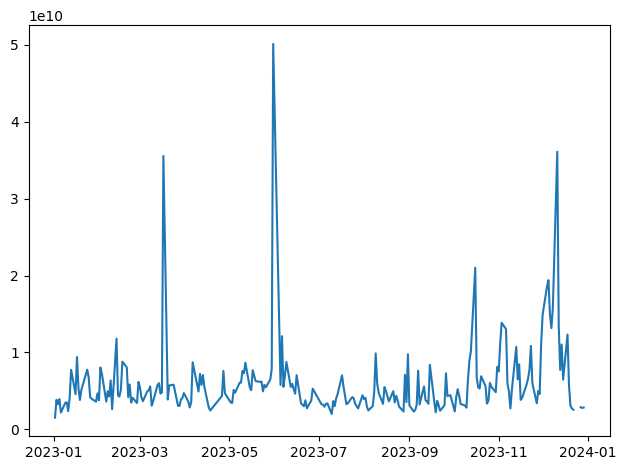

In [21]:
plt.plot(filtered_df_lq45['Tanggal'], filtered_df_lq45['Vol.'])

plt.tight_layout()
plt.show()

In [22]:
def aggregate_monthly_returns_perubahan(df):
    # 'month' untuk agregasi per bulan
    df['month'] = df['Tanggal'].dt.to_period('M')
    
    # Agregasi return bulanan dari 'Perubahan%' tertimbang volume
    monthly_returns = df.groupby('month').apply(
        lambda x: (x['Perubahan%'] * x['Vol.']).sum() / x['Vol.'].sum()
    ).reset_index(name='weighted_return_percentage')

    return monthly_returns

In [23]:
def simulate_portfolio_lq45(monthly_returns, initial_fund=1e8):
    portfolio_value = initial_fund
    portfolio_history = []

    # looping setiap bulan di monthly_returns
    for i, row in monthly_returns.iterrows():
        month = row['month']
        return_percentage = row['weighted_return_percentage'] / 100
        
        # update nilai portofolio berdasarkan return bulanan tertimbang
        portfolio_value *= (1 + return_percentage)

        portfolio_history.append({'Month': str(month),
                                  'Portfolio Value': portfolio_value})

    return pd.DataFrame(portfolio_history)

In [24]:
monthly_returns_lq45 = aggregate_monthly_returns_perubahan(filtered_df_lq45)
portfolio_history_lq45 = simulate_portfolio_lq45(monthly_returns_lq45)

# simulasi
portfolio_history_lq45

,Month,Portfolio Value
0,2023-01,1.001070e+08
1,2023-02,1.001399e+08
2,2023-03,1.005933e+08
3,2023-04,1.007773e+08
4,2023-05,1.009301e+08
5,2023-06,1.009314e+08
6,2023-07,1.010254e+08
7,2023-08,1.010203e+08
8,2023-09,1.009239e+08
9,2023-10,1.005497e+08


### Komparasi

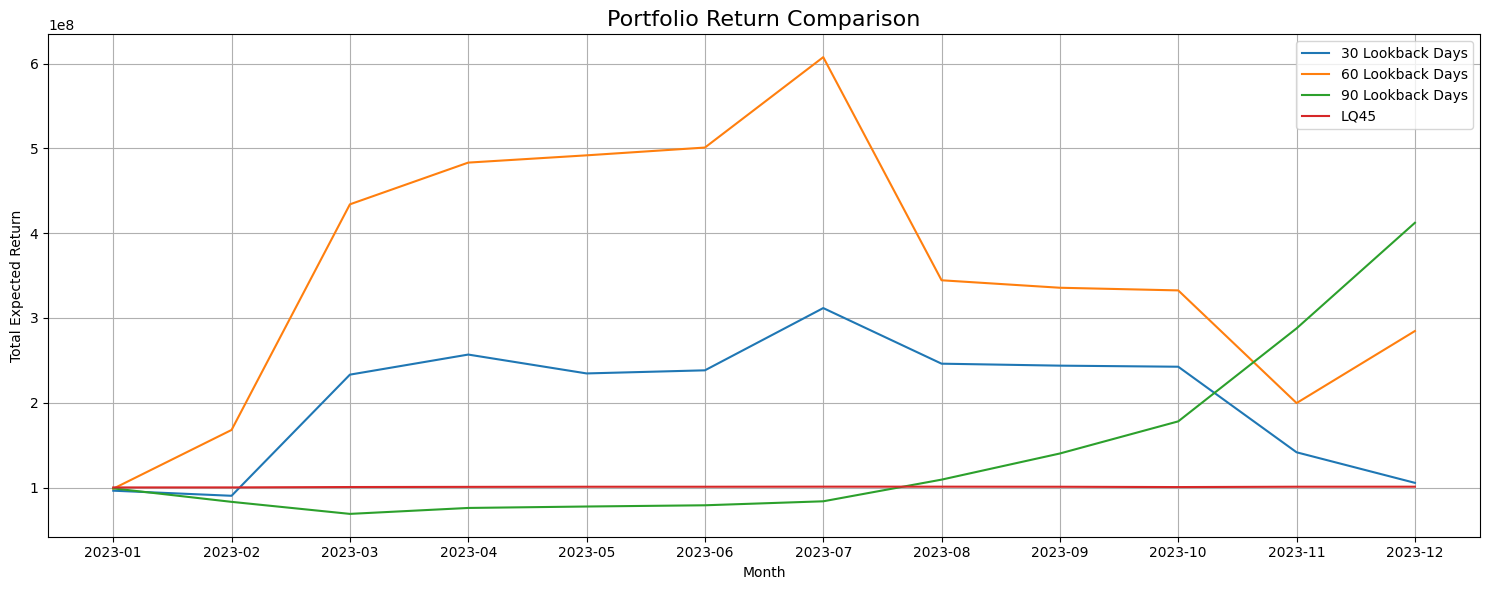

In [25]:
dataframes = [portfolio_history_30,
              portfolio_history_60,
              portfolio_history_90,
              portfolio_history_lq45]
labels = ["30 Lookback Days",
          "60 Lookback Days",
          "90 Lookback Days",
          "LQ45"]

plt.figure(figsize=(15, 6))
for df, label in zip(dataframes, labels):
    plt.plot(df['Month'], df['Portfolio Value'], label=label)

plt.xlabel('Month')
plt.ylabel('Total Expected Return')
plt.title('Portfolio Return Comparison', fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [27]:
def calculate_metrics(df_1, df_2, label):
    annualized_return = (df_2['Portfolio Value'].iloc[-1] / df_2['Portfolio Value'].iloc[0] - 1) * 100
    # volatility = df_1['portfolio_risk'].iloc[-1]
    drawdown = max(0, (df_2['Portfolio Value'].max() - df_2['Portfolio Value'].min()))

    return {
        'Label': label,
        'Annualized Return': f"{annualized_return:.2f}%",
        # 'Risk - Volatility': f"{volatility:.2f}%",
        'Drawdown': f"{drawdown:.2f}%",
    }

metrics_list = []
metrics_list.append(calculate_metrics(df_30, portfolio_history_30, "30 Lookback Days Portfolio"))
metrics_list.append(calculate_metrics(df_60, portfolio_history_60, "60 Lookback Days Portfolio"))
metrics_list.append(calculate_metrics(df_90, portfolio_history_90, "90 Lookback Days Portfolio"))
metrics_list.append(calculate_metrics(filtered_df_lq45, portfolio_history_lq45, "LQ45"))

print("Highlights")
# print("Return")
for metrics in metrics_list:
    print(f"{metrics['Label']}:")
    print(f"  Annualized Return: {metrics['Annualized Return']}")
    # print(f"  Risk - Volatility: {metrics['Risk - Volatility']}")
    print(f"  Drawdown: {metrics['Drawdown']}")
    print()


Highlights
30 Lookback Days Portfolio:
  Annualized Return: 9.60%
  Drawdown: 221364382.70%

60 Lookback Days Portfolio:
  Annualized Return: 188.55%
  Drawdown: 508912174.35%

90 Lookback Days Portfolio:
  Annualized Return: 316.41%
  Drawdown: 343295043.25%

LQ45:
  Annualized Return: 0.88%
  Drawdown: 918478.68%

